In [192]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import scipy.ndimage

In [193]:
outpath = './output'
result = 'stitched_pan2.png'

In [194]:
file_path = os.path.join(outpath, result)
img = cv2.imread(file_path)
H_transform = np.load('H_transform.npy')

In [195]:
def transform_point(pt):
    pt_homogeneous = np.array([pt[0], pt[1], 1])
    pt_transformed = H_transform @ pt_homogeneous
    pt_transformed /= pt_transformed[2]  # convert from homogeneous to euclidean coordinates
    return (int(pt_transformed[0]), int(pt_transformed[1]))


In [196]:
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [197]:
# Define polygon coordinates
polygon = np.array([[0, 188], [655, 203], [617, 655], [0, 655]], np.int32)
polygon = polygon.astype(int)  # convert the coordinates to integer
polygon = polygon.reshape((-1, 1, 2))

In [198]:
scale_factor = 0.75
points = []
with open('./logs/logtest', 'r') as file:
    for line in file:
        if "detected at" in line:
            tracker_id = int(line.split("Tracker")[1].split(":")[0].strip())
            coordinates = re.findall(r'\((.*?)\)', line)[0]  # Extract coordinates
            x, y = map(int, coordinates.split(","))

            
            if tracker_id == 1:  # Check if this is Tracker 1
                x, y = transform_point((x, y))
            else:
                x += 200         # Taking into account padding that was done to acquire original stitched image
                
            x = int(x * scale_factor)
            y = int(y * scale_factor)
            
            if cv2.pointPolygonTest(polygon, (x, y), False) >= 0 and tracker_id == 0:
                continue
                
            print(f"Tracker {tracker_id}: ({x}, {y})")
            
            # Draw the point on the image
            points.append((x, y))



Tracker 0: (642, 174)
Tracker 0: (640, 174)
Tracker 0: (639, 177)
Tracker 0: (636, 179)
Tracker 0: (633, 180)
Tracker 0: (630, 182)
Tracker 0: (628, 183)
Tracker 0: (626, 186)
Tracker 1: (619, 205)
Tracker 0: (627, 187)
Tracker 1: (618, 206)
Tracker 0: (627, 188)
Tracker 1: (616, 207)
Tracker 0: (625, 189)
Tracker 1: (616, 208)
Tracker 0: (624, 189)
Tracker 1: (616, 208)
Tracker 0: (623, 193)
Tracker 1: (615, 210)
Tracker 0: (622, 196)
Tracker 1: (614, 210)
Tracker 0: (620, 202)
Tracker 1: (615, 210)
Tracker 1: (613, 212)
Tracker 1: (612, 216)
Tracker 1: (612, 216)
Tracker 1: (610, 217)
Tracker 1: (608, 218)
Tracker 1: (603, 220)
Tracker 1: (603, 221)
Tracker 1: (603, 220)
Tracker 1: (604, 220)
Tracker 1: (604, 220)
Tracker 1: (606, 219)
Tracker 1: (605, 220)
Tracker 1: (605, 220)
Tracker 1: (604, 220)
Tracker 1: (603, 221)
Tracker 1: (603, 221)
Tracker 1: (600, 222)
Tracker 1: (598, 222)
Tracker 1: (598, 222)
Tracker 1: (599, 222)
Tracker 1: (598, 222)
Tracker 1: (597, 223)
Tracker 1:

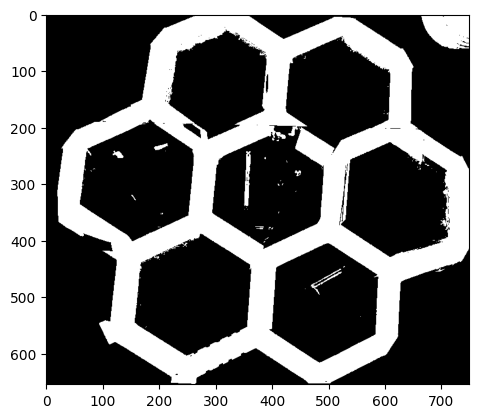

In [199]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply threshold
_, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)  # You may need to adjust the threshold value

# Save the mask
np.save('mask.npy', mask)

mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
plt.imshow(mask)
plt.show()


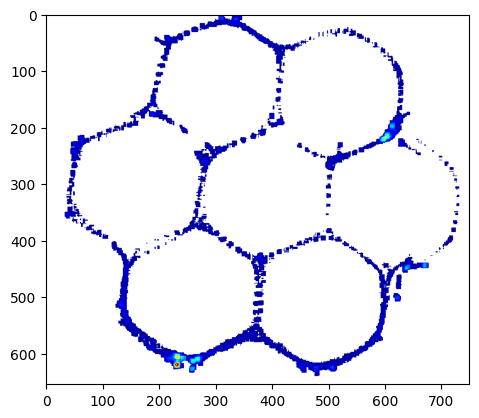

In [200]:
# Create a heatmap
heatmap = np.zeros_like(gray, dtype=np.float64)

# Define a 3x3 kernel with all values 1
kernel_size = 9
kernel_value = 10  # Increase this value for more intense lines
kernel = np.ones((kernel_size, kernel_size)) * kernel_value

for point in points:
    # Add the kernel to the heatmap at each point
    heatmap[point[1]-kernel_size//2:point[1]+kernel_size//2+1, 
            point[0]-kernel_size//2:point[0]+kernel_size//2+1] += kernel

# Find the maximum value in the heatmap
heatmap_max = np.max(heatmap)

# Normalize the heatmap and increase the base intensity
if heatmap_max != 0:
    heatmap_scaled = ((heatmap / heatmap_max) * 255)
else:
    heatmap_scaled = np.zeros_like(heatmap)

# Apply the color map to the heatmap
heatmap_img = cv2.applyColorMap(np.uint8(heatmap_scaled), cv2.COLORMAP_JET)

# Calculate the color intensity for the heatmap image
intensity = np.sum(heatmap_img, axis=2)

# Define a threshold
threshold = 50

# Create a mask for all colors with intensity above the threshold
mask_colour = intensity <= threshold * 3  # Multiply threshold by 3 because intensity is the sum of RGB values

# Replace all colors above the threshold with white
heatmap_img[mask_colour] = [255, 255, 255]

# Show the result
plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
plt.show()


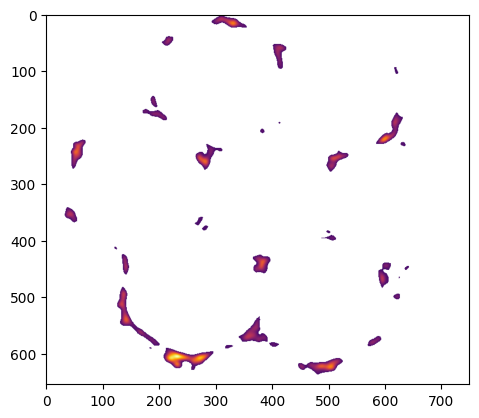

In [210]:
# Create a heatmap
heatmap = np.zeros_like(gray, dtype=np.float64)

# Create an intermediate image to draw lines
intermediate = np.zeros_like(gray, dtype=np.uint8)

# Define a line thickness
line_thickness = 1

for i in range(1, len(points)):
    if distance(points[i-1], points[i]) < 10:
    # Draw the line on the intermediate image
        cv2.line(intermediate, points[i - 1], points[i], (255), thickness=line_thickness)
#         cv2.circle(intermediate, points[i - 1], line_thickness, (255), -1)

# Add the intermediate image to the heatmap
heatmap += intermediate.astype(np.float64)

# Apply a Gaussian blur to the heatmap to increase the hotspot radius
heatmap = cv2.GaussianBlur(heatmap, (25, 25), 0)

# Find the maximum value in the heatmap
heatmap_max = np.max(heatmap)

# Normalize the heatmap
if heatmap_max != 0:
    heatmap_scaled = ((heatmap / heatmap_max) * 255)
else:
    heatmap_scaled = np.zeros_like(heatmap)

# Apply the color map to the heatmap
heatmap_img = cv2.applyColorMap(np.uint8(heatmap_scaled), cv2.COLORMAP_INFERNO)

# Calculate the color intensity for the heatmap image
intensity = np.sum(heatmap_img, axis=2)

# Define a threshold
threshold = 60

# Create a mask for all colors with intensity above the threshold
mask_colour = intensity <= threshold * 3  # Multiply threshold by 3 because intensity is the sum of RGB values

# Replace all colors above the threshold with white
heatmap_img[mask_colour] = [255, 255, 255]

# Show the result
plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
plt.show()


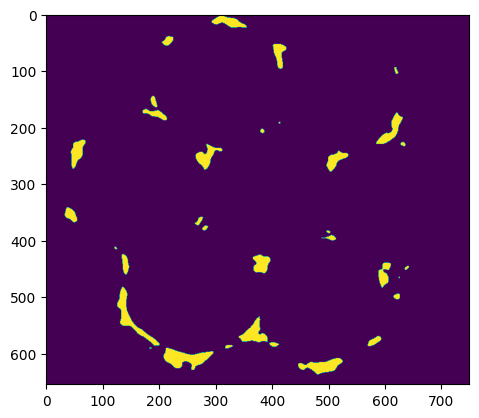

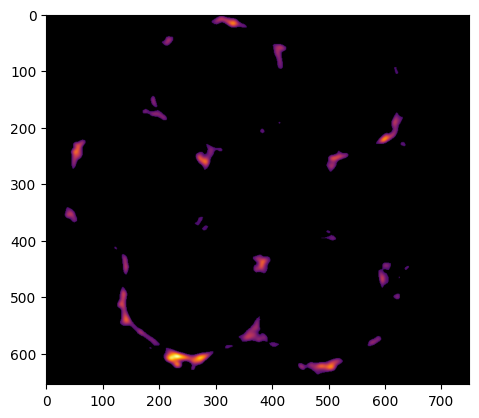

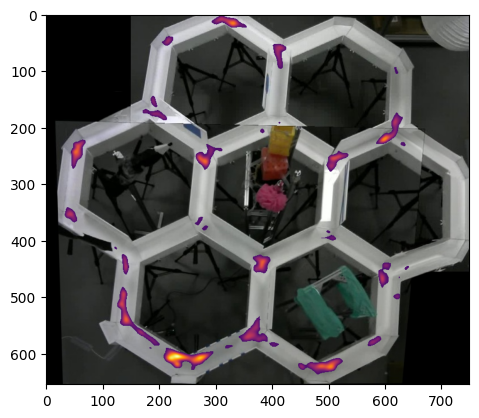

In [211]:
scaled_heatmap = cv2.convertScaleAbs(heatmap_img, alpha=1, beta=2)


# Convert the heatmap to grayscale
heatmap_gray = cv2.cvtColor(scaled_heatmap, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale heatmap to create a binary mask
# All white pixels (values above 254) will be set to 0 (black), 
# and all other pixels will be set to 255 (white)
_, mask_heatmap = cv2.threshold(heatmap_gray, 254, 255, cv2.THRESH_BINARY_INV)
plt.imshow(mask_heatmap)
plt.show()

# Convert the binary mask to a three channel image
fg = cv2.bitwise_and(cv2.cvtColor(scaled_heatmap, cv2.COLOR_BGR2RGB), cv2.cvtColor(scaled_heatmap, cv2.COLOR_BGR2RGB), mask=mask_heatmap)
plt.imshow(fg)
plt.show()

img_with_heatmaps = np.zeros_like(fg)

for c in range(0,3):
    for i in range(0, fg.shape[0]):
        for j in range(0, fg.shape[1]):
            if fg[i, j, c] == 0:
                img_with_heatmaps[i, j, c] = img[i, j, 2-c]
            else:
                img_with_heatmaps[i, j, c] = fg[i, j, c] 
plt.imshow(img_with_heatmaps)
plt.show()

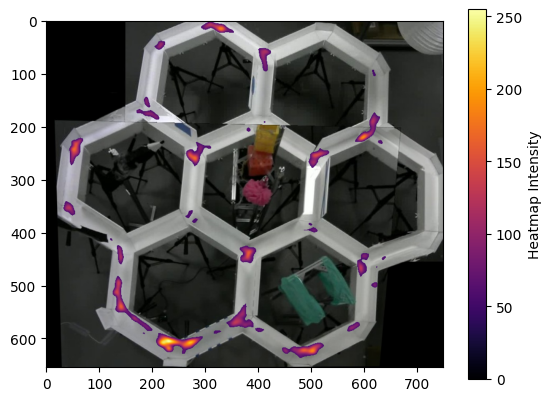

In [213]:
import matplotlib as mpl

# Generate a figure and a set of subplots
fig, ax = plt.subplots()

# Show the image with the heatmap overlay
ax.imshow(img_with_heatmaps)

# Use the inferno colormap provided by matplotlib
cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=0, vmax=255)

# Create a colorbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Heatmap Intensity')

plt.show()
